In [1]:
#Importing the librearies:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from sklearn.model_selection import train_test_split
from datetime import timedelta

import sys
sys.path.insert(0, "..")
from models.LinearRegression_ClosedForm import LinearRegression_ClosedForm
from models.LinearRegression_SGD import LinearRegression_SGD


In [2]:
SAVE_DIR = Path(r'../../../data/assignment1/processed')

# Load parsed dataset
data = pd.read_csv(SAVE_DIR / 'DK1.csv', index_col=0)

data = data.head(200)

In [3]:
# Add actual wind power of the previous day to data
current_day = data['StartTimeUTC']
df_times = data.query("StartTimeUTC == @current_day")

previous_day = pd.to_datetime(current_day) - timedelta(days = 1)

df_values = []

for i, day in enumerate(previous_day):
    day = str(day)
    df_times = data.query("StartTimeUTC == @day")
    value = 0 if df_times['Actual'].empty else df_times['Actual'].values[0]
    df_values.append(value)

data['power_previous_day'] = df_values    


In [4]:
# Add average wind power of the previous week as a new column
current_day = data['StartTimeUTC']
power_last_week = []

for i, day in enumerate(current_day):
      previous_week = str(pd.to_datetime(day) - timedelta(weeks = 1))
      df_times = data.query("StartTimeUTC <= @day and StartTimeUTC > @previous_week")

      df_values = df_times['Actual'].values
      
      total_power = sum(df_values)
      avg_power = total_power / len(df_values)
      power_last_week.append(avg_power)
           
data['avg_power_previous_week'] = power_last_week  

In [5]:
print(data.head())
print(data.describe())
print(data.info())
print(data.shape)

                 StartTimeUTC                 EndTimeUTC PriceArea    Actual  \
1   2021-01-01 00:00:00+00:00  2021-01-01 01:00:00+00:00       DK1  0.234708   
8   2021-01-01 01:00:00+00:00  2021-01-01 02:00:00+00:00       DK1  0.223329   
15  2021-01-01 02:00:00+00:00  2021-01-01 03:00:00+00:00       DK1  0.172119   
22  2021-01-01 03:00:00+00:00  2021-01-01 04:00:00+00:00       DK1  0.160740   
29  2021-01-01 04:00:00+00:00  2021-01-01 05:00:00+00:00       DK1  0.129445   

    SpotPriceDKK  SpotPriceEUR  BalancingMarketPrice_DownReg  \
1     358.579987     48.189999                         24.35   
8     332.459991     44.680000                         23.98   
15    319.369995     42.919998                         23.72   
22    300.540009     40.389999                         23.73   
29    299.130005     40.200001                         24.06   

    BalancingMarketPrice_UpReg  max_wind_speed_10min  max_wind_speed_3sec  \
1                        24.35                   4.6     

c:\Users\enach\.conda\envs\ml_final_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


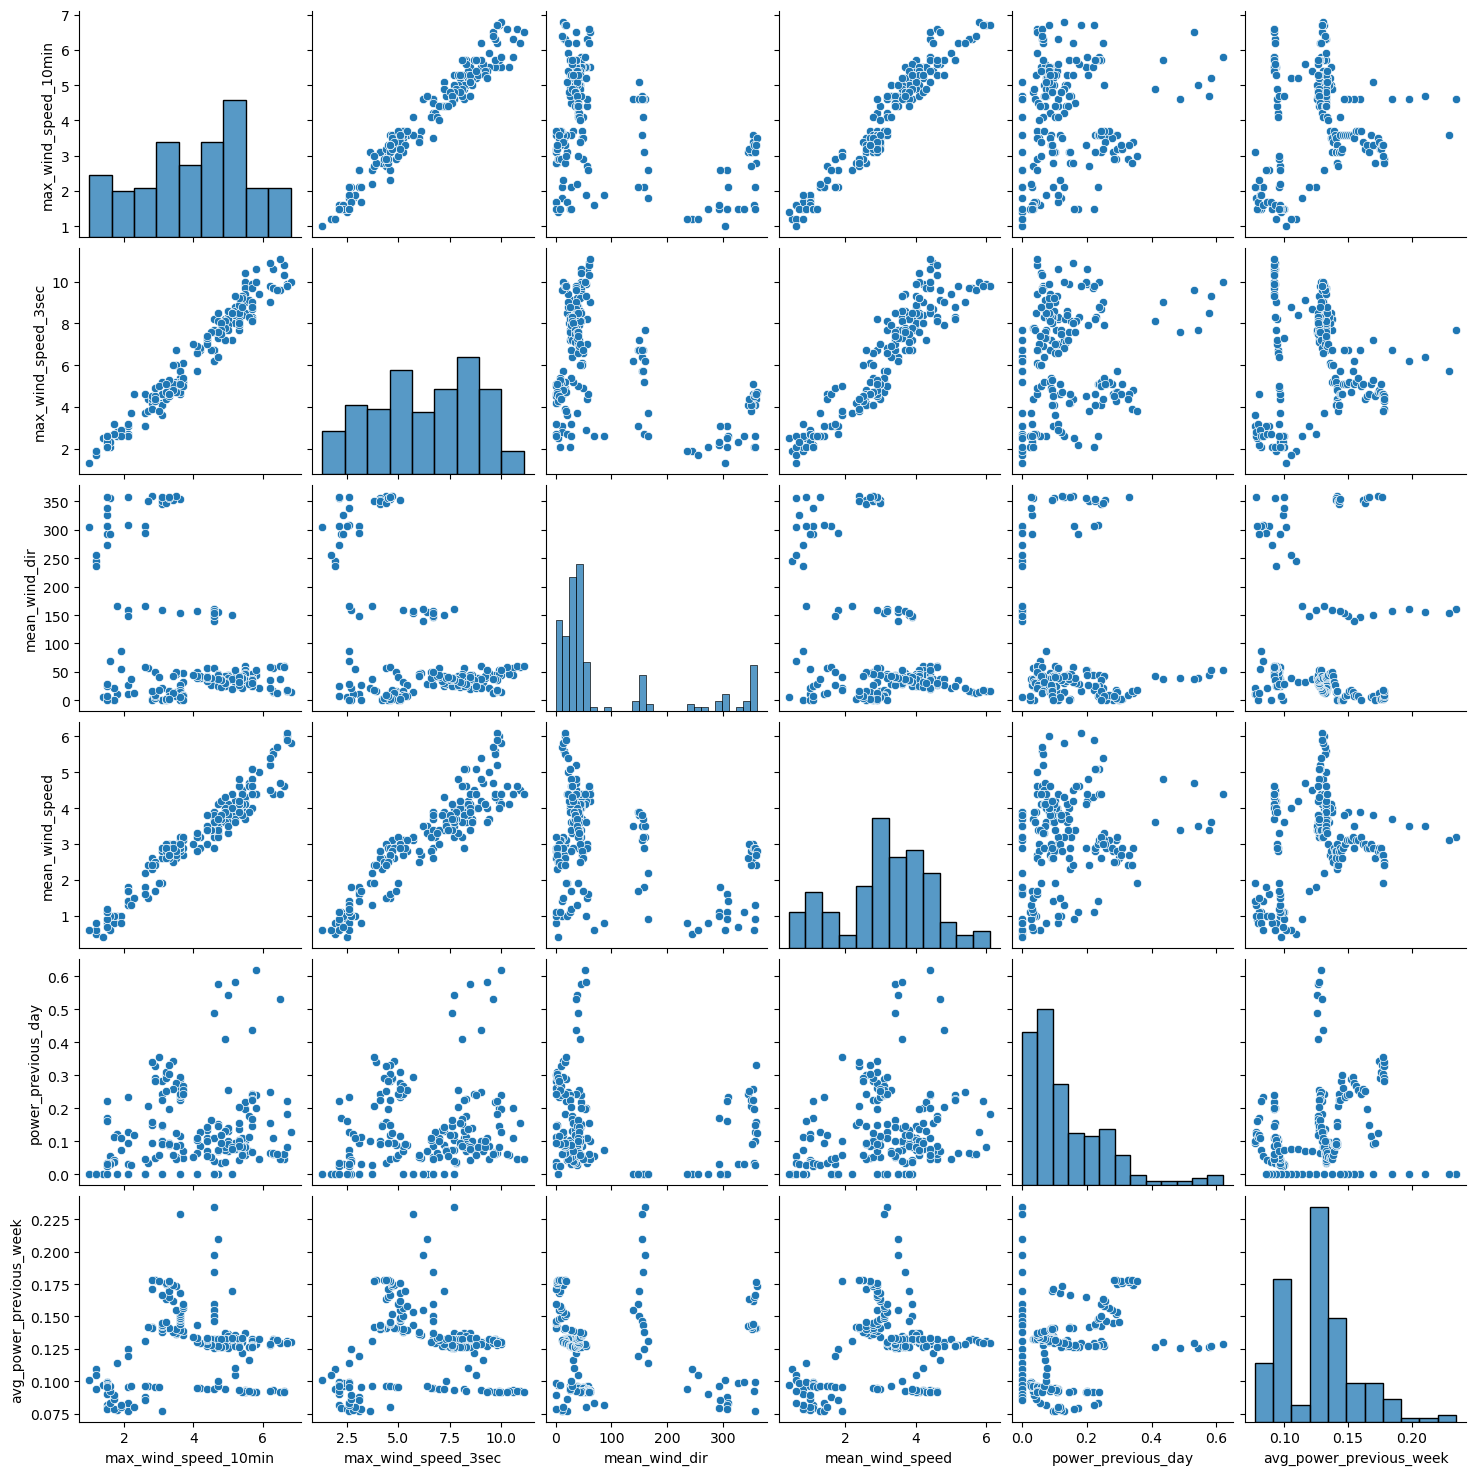

In [6]:
sns.pairplot(data=data, vars=["max_wind_speed_10min", "max_wind_speed_3sec", "mean_wind_dir", "mean_wind_speed", "power_previous_day", "avg_power_previous_week"])
plt.show()

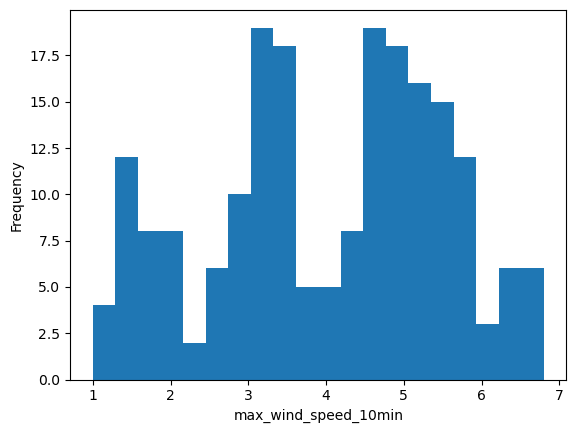

In [7]:
plt.hist(data["max_wind_speed_10min"], bins=20)
plt.xlabel("max_wind_speed_10min")
plt.ylabel("Frequency")
plt.show()


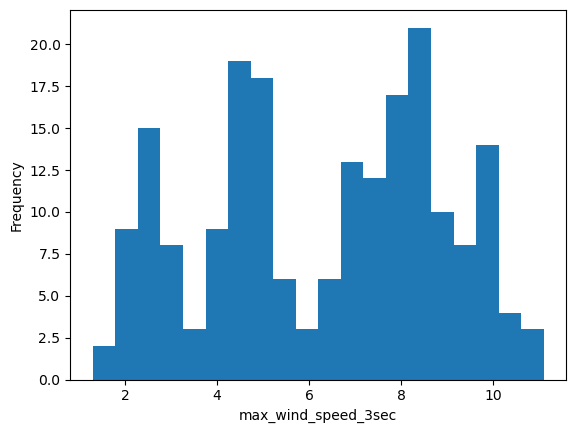

In [8]:
plt.hist(data["max_wind_speed_3sec"], bins=20)
plt.xlabel("max_wind_speed_3sec")
plt.ylabel("Frequency")
plt.show()

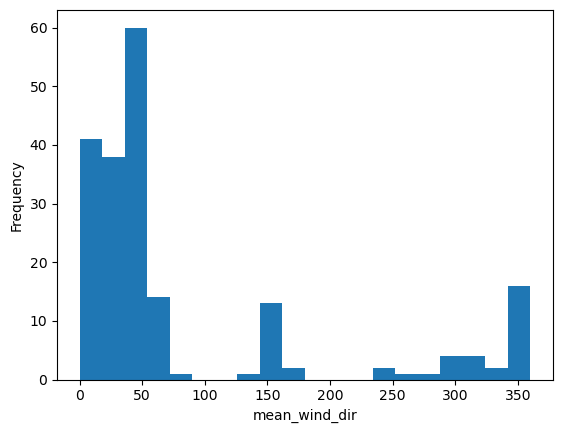

In [9]:
plt.hist(data["mean_wind_dir"], bins=20)
plt.xlabel("mean_wind_dir")
plt.ylabel("Frequency")
plt.show()

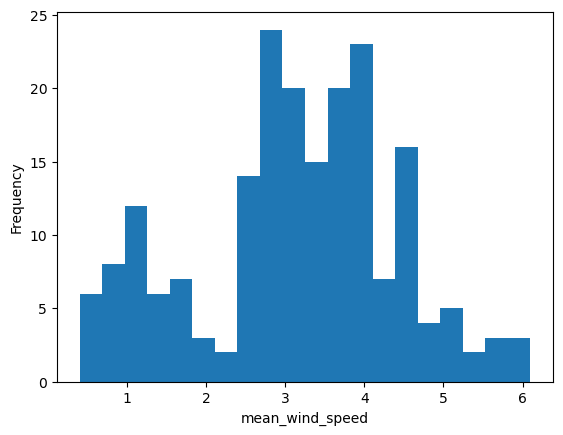

In [10]:
plt.hist(data["mean_wind_speed"], bins=20)
plt.xlabel("mean_wind_speed")
plt.ylabel("Frequency")
plt.show()

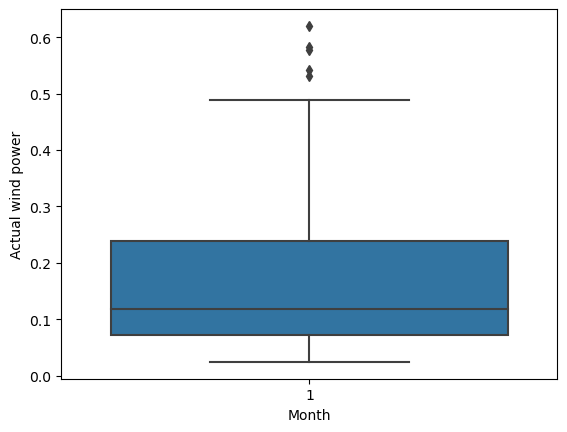

In [11]:
# Box plot of LV ActivePower by month
data["Month"] = pd.to_datetime(data["StartTimeUTC"]).dt.month
sns.boxplot(x="Month", y="Actual", data=data)
plt.xlabel("Month")
plt.ylabel("Actual wind power")
plt.show()


#### Selecting features: 
*["max_wind_speed_10min", "max_wind_speed_3sec","mean_wind_dir", "mean_wind_speed", "power_previous_day", "avg_power_previous_week" ]*

In [12]:
# Preparing the data:
from sklearn import preprocessing

X = data[["max_wind_speed_10min", "max_wind_speed_3sec","mean_wind_dir", "mean_wind_speed", "power_previous_day", "avg_power_previous_week" ]]

# all values should lie between 0 and 1
normalized_X = preprocessing.normalize(X)

#print(normalized_X)
y = data['Actual']

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, random_state=0)

### SGD Regressor

In [13]:
model = SGDRegressor(alpha= 0.0001, max_iter = 100)
model.fit (X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the coefficients and intercept:

print("Coefficients:", model.coef_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Coefficients: [0.0206592  0.03081832 0.06319534 0.01752791 0.00106145 0.00086482]
Mean Squared Error: 0.020115299605477747
Mean Absolute Error: 0.11698841891307363
R-squared: -0.07521308163947293


### Custom SGD regressor

In [14]:
model = LinearRegression_SGD()
model.fit (X_train, y_train, alpha= 0.001, n_iterations = 10000)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the coefficients and intercept:

print("Coefficients:", model.weights)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Coefficients: [0.03785118 0.0547367  0.04472096 0.03410113 0.00207471 0.00171815]
Mean Squared Error: 0.020113222658905777
Mean Absolute Error: 0.11723226929670616
R-squared: -0.07510206364979122


### Closed form

In [15]:
lr = LinearRegression_ClosedForm(fit_intercept=True)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the coefficients and intercept:

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490475
Mean Squared Error: 0.020739359191298722
Mean Absolute Error: 0.1187783307662283
R-squared: -0.10857062756508795


### Custom linear regression closed form

In [16]:
# Building the model:

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluating the model, calculating metrics:

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the coefficients and intercept:

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 0.02073935919129868
Mean Absolute Error: 0.11877833076622821
R-squared: -0.10857062756508573


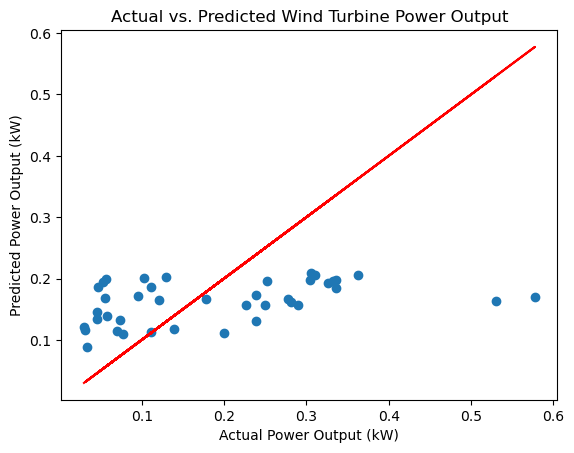

In [21]:
# Creating a scatter plot of the actual output (y_test) vs. the predicted output (y_pred) using matplotlib's scatter() function:

plt.scatter(y_test, y_pred)
#print(y_pred)
#obtain m (slope) and b(intercept) of linear regression line
#m, b = np.polyfit(X_test["max_wind_speed_10min"], y_pred, 1)
plt.plot(y_test, y_test, color='red')

# Adding labels for the x-axis, y-axis, and title using matplotlib's xlabel(), ylabel(), and title() functions:

plt.xlabel("Actual Power Output (kW)")
plt.ylabel("Predicted Power Output (kW)")
plt.title("Actual vs. Predicted Wind Turbine Power Output")

## Displaying the plot using matplotlib's show() function:

plt.show()

### Nonlinear regression

### Selecting features

In [18]:
# Preparing the data:
from sklearn import preprocessing

X = data[["max_wind_speed_10min", "max_wind_speed_3sec","mean_wind_dir", "mean_wind_speed", "power_previous_day", "avg_power_previous_week" ]]
#normalized_X = preprocessing.normalize(X)
#print(normalized_X)
y = data['Actual']


In [19]:
from sklearn.preprocessing import PolynomialFeatures

degrees = [2, 3, 5, 7, 10, 15, 20]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X)

    # Splitting the data:
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=0)


    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train, y_train)
    y_pred = poly_reg_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Printing the coefficients and intercept:
    print("Evalution metrics for degree = ", degree)
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)
    print()

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred)
# plt.plot(y_test, y_test, c="red")
# plt.show()

Evalution metrics for degree =  2
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 0.012727375574835751
Mean Absolute Error: 0.08330602436230997
R-squared: 0.3196899384349443

Evalution metrics for degree =  3
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 0.05385590744001496
Mean Absolute Error: 0.15589210333461104
R-squared: -1.8787329713597574

Evalution metrics for degree =  5
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 10098.098749993098
Mean Absolute Error: 43.260836890642416
R-squared: -539767.6382321183



Evalution metrics for degree =  7
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 137955781.4184832
Mean Absolute Error: 4228.195390499646
R-squared: -7374081607.436771

Evalution metrics for degree =  10
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 2623740042.1982384
Mean Absolute Error: 16933.009204782313
R-squared: -140245468449.5231

Evalution metrics for degree =  15
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 24359040999.85856
Mean Absolute Error: 50651.90345171016
R-squared: -1302051674740.5425

Evalution metrics for degree =  20
Coefficients: [-0.58010464 -0.0212107   0.00512512  0.91289636 -1.75847819  3.35185487]
Intercept: 0.12828827433490297
Mean Squared Error: 4573718867.02435
Mean Absolute Error: 

In [20]:
# Building the model:
# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluating the model, calculating metrics:

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the coefficients and intercept:

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Coefficients: [-5.93986990e-02  6.69286898e-03 -3.08220211e-05  6.08198756e-02
  1.86505455e-03  7.94593022e-01]
Intercept: 0.06460075210792737
Mean Squared Error: 0.016782204072129662
Mean Absolute Error: 0.1054289896228279
R-squared: 0.10294921224125198


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression
# feature selection
def select_features(X_train, y_train, X_test, n_features):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=n_features)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from src.assignment1.models.LinearRegression_ClosedForm import LinearRegression_ClosedForm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Get design matrices
X, y, data, col2idx = design_matrix(DK2_dataset)
print(X.shape)
# all values should lie between 0 and 1
normalized_X = preprocessing.normalize(X)
# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, random_state=0)

# feature selection
for i in range(len(X[0])):
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, n_features=i+1)

    lr = LinearRegression_ClosedForm(fit_intercept=True)
    lr.fit(X_train_fs, y_train)

    y_pred = lr.predict(X_test_fs)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Printing the coefficients and intercept:
    print("N features = ", i)
    # print("Coefficients:", lr.coef_)
    # print("Intercept:", lr.intercept_)
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)
    print()

print(X_train_fs, X_test_fs, fs)
print(fs.get_feature_names_out())
print(data.shape)